# Fish-eye camera
A downward-looking commercial digital camera equipped with a 180°-fisheye lens was installed on the aircraft Polar 5. Images of the Arctic surface and clouds were taken every 4-6 seconds. The data set provides rectified fields of calibrated radiances along the flight track for the three spectral bands (red, green, and blue). The full dataset is available on PANGAEA for [ACLOUD](https://doi.pangaea.de/10.1594/PANGAEA.901024), [AFLUX](https://doi.pangaea.de/10.1594/PANGAEA.933839) and [MOSAiC-ACA](https://doi.pangaea.de/10.1594/PANGAEA.933849). In the next sections, the data is loaded from the PANGAEA database and a cloudy scene over sea ice is plotted.

## Data access
* To analyse the data they first have to be loaded by importing the (AC)³airborne meta data catalogue. To do so the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

## Get data

In [1]:
import ac3airborne

In [2]:
cat = ac3airborne.get_intake_catalog()

datasets = []
for campaign in ['ACLOUD', 'AFLUX', 'MOSAiC-ACA']:
    datasets.extend(list(cat[campaign]['P5']['FISH_EYE_CAMERA']))
datasets

['ACLOUD_P5_RF05',
 'ACLOUD_P5_RF06',
 'ACLOUD_P5_RF07',
 'ACLOUD_P5_RF08',
 'ACLOUD_P5_RF10',
 'ACLOUD_P5_RF11',
 'ACLOUD_P5_RF13',
 'ACLOUD_P5_RF14',
 'ACLOUD_P5_RF15',
 'ACLOUD_P5_RF16',
 'ACLOUD_P5_RF17',
 'ACLOUD_P5_RF18',
 'ACLOUD_P5_RF19',
 'ACLOUD_P5_RF20',
 'ACLOUD_P5_RF21',
 'ACLOUD_P5_RF22',
 'ACLOUD_P5_RF23',
 'ACLOUD_P5_RF25',
 'AFLUX_P5_RF03',
 'AFLUX_P5_RF04',
 'AFLUX_P5_RF05',
 'AFLUX_P5_RF06',
 'AFLUX_P5_RF07',
 'AFLUX_P5_RF08',
 'AFLUX_P5_RF09',
 'AFLUX_P5_RF10',
 'AFLUX_P5_RF11',
 'AFLUX_P5_RF12',
 'AFLUX_P5_RF13',
 'AFLUX_P5_RF14',
 'AFLUX_P5_RF15',
 'MOSAiC-ACA_P5_RF04',
 'MOSAiC-ACA_P5_RF05',
 'MOSAiC-ACA_P5_RF06',
 'MOSAiC-ACA_P5_RF07',
 'MOSAiC-ACA_P5_RF08',
 'MOSAiC-ACA_P5_RF09',
 'MOSAiC-ACA_P5_RF10',
 'MOSAiC-ACA_P5_RF11']

```{note}
Have a look at the attributes of the xarray dataset `ds_cam` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [3]:
ds_cam = cat['ACLOUD']['P5']['FISH_EYE_CAMERA']['ACLOUD_P5_RF05'](hour='10').to_dask()
ds_cam

Invalid MIT-MAGIC-COOKIE-1 key

ClientResponseError: 503, message='Service Unavailable', url=URL('https://hs.pangaea.de/Projects/AC3/ACLOUD_rad-fields/Canon_radiance_P5_170525_10UTC_Flight_05.nc')

The dataset includes the red, green and blue radiances (`radiance_red`, `radiance_green`, `radiance_blue`), the camera's zenith and azimuth angles (`vza`, `vaa`), and information on the aircraft's flight altitude (`altitude`) and position (`latitude`, `longitude`).

Next, the time is converted from dec UTC to datetime:

In [20]:
import datetime
import numpy as np

def convert_time(ds):
    """
    Convert time 
    """

    date = datetime.datetime.strptime(ds.attrs['Comment'], 'Date %Y-%m-%d')
    time = np.array([(date + datetime.timedelta(hours=h)).replace(microsecond=0) for h in ds.time.values.astype('float')])
    
    ds['time'] = (('dim_t'), time)
    
    return ds

In [33]:
print(ds_cam.time.dtype)
ds_cam = convert_time(ds_cam)
print(ds_cam.time.dtype)

float32
datetime64[ns]


## Plots

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
plt.style.use("../mplstyle/book")

In [37]:
def scaling(x, a, b, x_min=None, x_max=None):
    """    
    Scale values x in new range from a to b
    """
    
    if x_min is None:
        x_min = np.min(x)

    if x_max is None:
        x_max = np.max(x)
        
    x_scaled = a + (x-x_min) * (b-a) / (x_max-x_min)
    
    return x_scaled

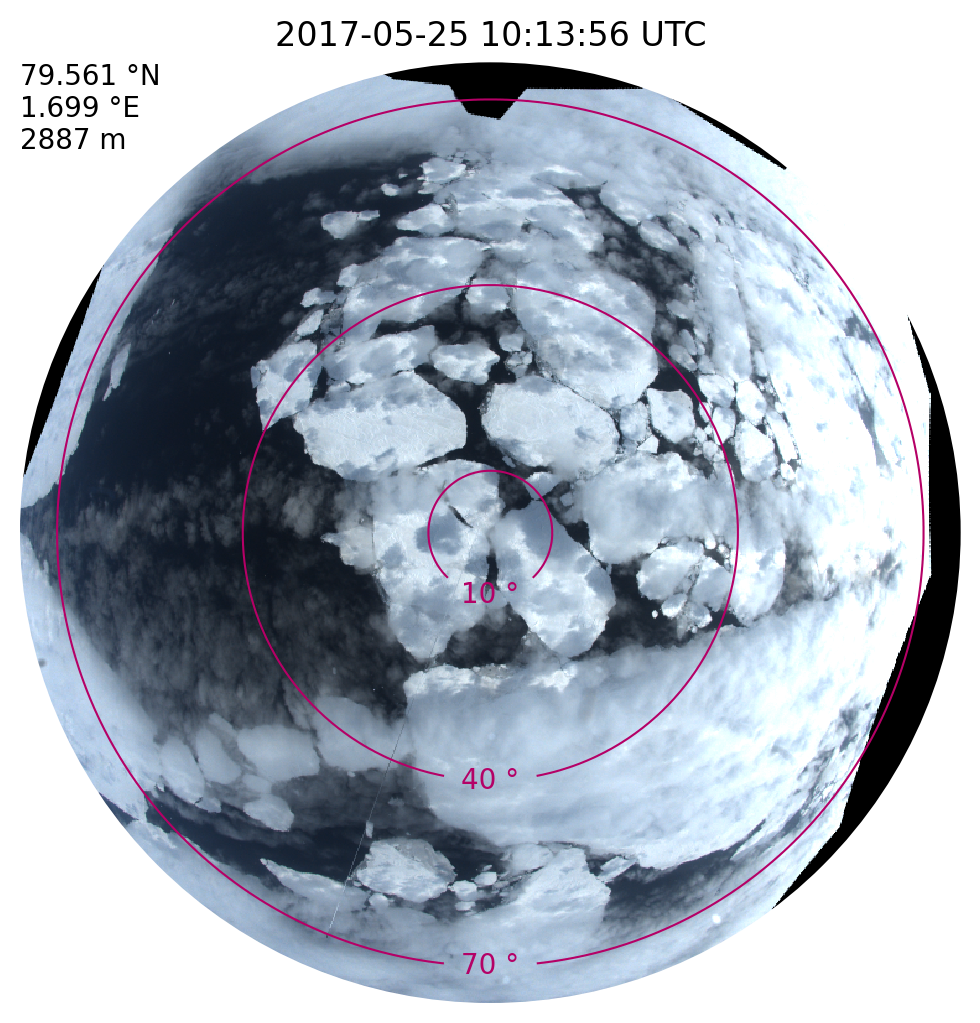

In [38]:
# select timestep
t = 117

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

# 1: convert radiances to RGB image
rgb = np.stack([ds_cam[c].sel(dim_t=t) for c in ['radiance_red', 'radiance_green', 'radiance_blue']])

# scale radiances between 0 and 255, with 255 = 95th percentile of RGB radiances
max_radiance = np.percentile(rgb, 95)
rgb = scaling(x=rgb.astype('float64'), 
              a=0, 
              b=255, 
              x_min=0, 
              x_max=max_radiance)
rgb = np.round(rgb, 0).astype('int')
rgb = rgb.transpose(1, 2, 0)
# set values that exceed the 95 percentile
rgb[rgb > 255] = 255
im = ax.imshow(rgb, interpolation='nearest')

# zoom into center of image
center = 450
radius = 380
patch = patches.Circle((center, center), radius=radius, fc='none')
ax.add_patch(patch)
im.set_clip_path(patch)

# set axis limits: image origin is upper left corner
ax.set_xlim(center-radius, center+radius)
ax.set_ylim(center+radius, center-radius)

# 2: show viewing angle grid
ct_vza = ax.contour(ds_cam.dim_x, ds_cam.dim_y, ds_cam.vza*1e-2, levels=np.array([10, 40, 70]), colors='#B50066', linestyles='-', linewidths=0.75)
ax.clabel(ct_vza, fmt='%1.0f °', manual=[(center, 490), (center, 640), (center, 800)])

# 3: add meta information
alt = ds_cam.altitude.sel(dim_t=t).values.item()
time = datetime.datetime.utcfromtimestamp((ds_cam.time.sel(dim_t=t).values - np.datetime64('1970-01-01 00:00:00')) / np.timedelta64(1, 's'))
lon = ds_cam.longitude.sel(dim_t=t).values.item()
lat = ds_cam.latitude.sel(dim_t=t).values.item()

txt = '{} °N\n{} °E\n{} m'.format(np.round(lat, 3), np.round(lon, 3), int(np.round(alt, 0)))
ax.annotate(txt, xy=(center-radius, center-radius), xycoords='data', ha='left', va='top')

time_txt = time.strftime('%Y-%m-%d %H:%M:%S UTC')
ax.set_title(time_txt)

ax.axis('off')

plt.show()